In [ ]:
%load_ext autoreload
%autoreload 2
import utils.models as models  # noqa: F403
import utils.api as api

CACHED_HOURLY_DATA = "cached_hourly_data.json"
CACHED_FORCAST_DATA = "cached_forecast_data.json"
CACHED_RAW_DATA = "cached_raw_data.json"

FORCASTS = (CACHED_FORCAST_DATA, CACHED_HOURLY_DATA, CACHED_RAW_DATA)
# api.update_all_forecasts()

In [3]:
data = api.load_cached_data(CACHED_RAW_DATA)

In [16]:
m = models.GridpointGeoJson.model_validate(data)


In [5]:
import pandas as pd

df = pd.DataFrame(m.properties.apparentTemperature.values)  # type: ignore
df.value = df.value * 9 / 5 + 32  # Convert to Fahrenheit


In [6]:
df["dur"] = df["validTime"].apply(
    lambda x: x.split("/")[1] if len(x.split("/")) > 1 else None
)

In [7]:
df["starttime"] = df["validTime"].apply(
    lambda x: x.split("/")[0] if len(x.split("/")) > 0 else None
)

In [ ]:
df.index = df.starttime  # type: ignore

In [9]:
df["duration"] = df["dur"].apply(
    lambda x: int(x.split("PT")[1].replace("H", "")) if x else None
)

In [10]:
df.drop(columns=["dur"], inplace=True)

In [11]:
df.index = pd.to_datetime(df.index)  # yields tz-aware UTC timestamps


In [12]:
df.head()

,validTime,value,starttime,duration
starttime,,,,
2025-06-20 12:00:00+00:00,2025-06-20T12:00:00+00:00/PT1H,65.0,2025-06-20T12:00:00+00:00,1
2025-06-20 13:00:00+00:00,2025-06-20T13:00:00+00:00/PT1H,68.0,2025-06-20T13:00:00+00:00,1
2025-06-20 14:00:00+00:00,2025-06-20T14:00:00+00:00/PT1H,71.0,2025-06-20T14:00:00+00:00,1
2025-06-20 15:00:00+00:00,2025-06-20T15:00:00+00:00/PT1H,74.0,2025-06-20T15:00:00+00:00,1
2025-06-20 16:00:00+00:00,2025-06-20T16:00:00+00:00/PT1H,76.0,2025-06-20T16:00:00+00:00,1


C:\Users\ajm89\AppData\Local\Temp\ipykernel_6816\316197794.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_idx = pd.date_range(


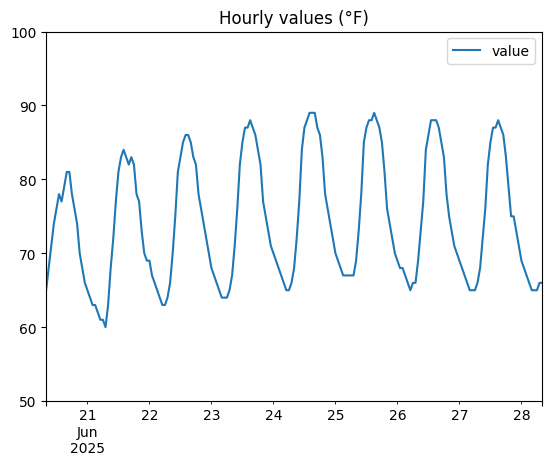

In [ ]:
import pandas as pd

# Ensure starttime is datetime
# 1. Parse your timestamps and set them as an index
df["starttime"] = pd.to_datetime(df["starttime"])  # yields tz-aware UTC timestamps
df = df.set_index("starttime").sort_index()

# 2. Build a complete hourly index from first to last time
full_idx = pd.date_range(
    start=df.index.min(), end=df.index.max() + pd.Timedelta(hours=1), freq="H", tz="UTC"
)

# 3. Reindex + forward-fill to “unpack” multi-hour blocks
#    duration=2 entries will automatically fill the missing hour
df_hourly = df.reindex(full_idx, method="ffill")

# 4. (Optional) Drop the now-redundant duration column
df_hourly = df_hourly[["value"]]

# 5. Convert into your local timezone
df_hourly = df_hourly.tz_convert("America/New_York")

# 6. Now you can…
#    • plot it:
ax = df_hourly.plot()
ax.set_ylim(50, 100)
ax.set_title("Hourly values (°F)")  # or whatever unit/value you’re using

#    • compute daily stats:
daily = df_hourly.resample("D").agg(["min", "max", "mean"])

#    • compute rolling windows:
roll3h = df_hourly.rolling(3).mean()

#    • export:
df_hourly.to_csv("hourly_values_nyc.csv")
